# Implementar un sistema de inferencia difusa para controlar un péndulo invertido
---

## Análisis del modelo físico del péndulo invertido

Las constantes del modelo físico son las siguientes:

In [7]:
from math import sin, cos, pow, pi

#--------------------------------------------------
# Constantes del modelo
#--------------------------------------------------
g = 9.81    # [m/s^2]   Aceleración de la gravedad
F = 0       # [N]       Fuerza externa
m = 0.2     # [Kg]      Masa del péndulo
l = 0.5     # [m]       Longitud del péndulo
M = 2       # [Kg]      Masa del carro
#--------------------------------------------------

A continuación se calcula el modelo en el tiempo, sin aplicar ningún tipo de control:

In [9]:
def update(x, dt):

    x_t = x
    
    num = g * sin(x[0]) + cos(x[0]) * (- F - m * l * pow(x[1], 2) * sin(x[0])) / (M + m)
    den = l * (4/3 - m * pow(cos(x[0]), 2) / (M + m))

    x_t[2] = num / den

    x_t[1] = x[1] + x[2]*dt
    x_t[0] = x[0] + x[1]*dt + x[2]*pow(dt, 2)/2

    return x_t

In [10]:
MAX_ITER = 2000

dt = 0.001
t = 0

x = [-pi + 0.01, 0, 0]

pos = []
vel = []
acel = []
time = []

while(t < MAX_ITER):

    pos.append(x[0])
    vel.append(x[1])
    acel.append(x[2])

    x = update(x, dt)

    time.append(t)

    t += dt

Las gráficas de ángulo $\theta$, velocidad angular y aceleración angular en el tiempo son:

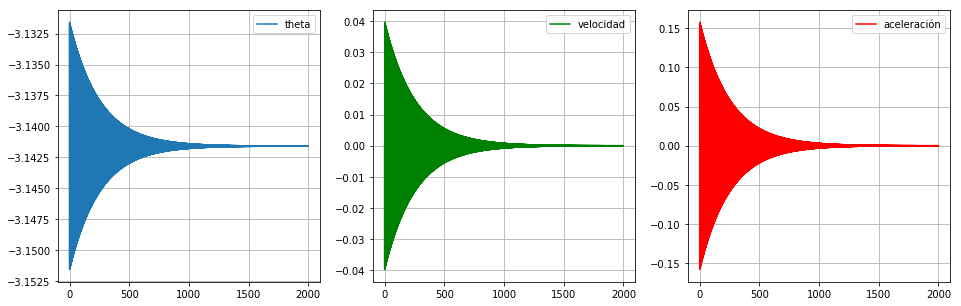

In [19]:
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))

ax0.plot(time, pos, label="theta")
ax0.grid()
ax0.legend(loc="upper right")

ax1.plot(time, vel, color='g', label="velocidad")
ax1.grid()
ax1.legend(loc="upper right")

ax2.plot(time, acel, color='r', label="aceleración")
ax2.grid()
ax2.legend(loc="upper right")

plt.show()

A pesar de que el modelo no considera ningún tipo de amortiguamiento, puede observarse cómo el sistema "pierde energía". Esto es debido a que el análisis es discreto, y a lo largo de las iteraciones se acumula un error cada vez que el péndulo llega a los extremos, produciendo un efecto similar al de un amortiguamiento.

## Definición de las variables linguísticas y los conjuntos borrosos de entrada

Se elige como variables de entrada el ángulo $\theta$ y la velocidad angular. Ambos conjuntos borrosos pueden tomar valores *MN*, muy negativo, *N*, negativo, *Z*, cero, *P*, positivo y *MP*, muy positivo.

In [23]:
from numpy import arange

from fuzzy_logic import generate_profile

T_STEP = 5
V_STEP = 0.005
A_STEP = 0.01

theta = []
v = []

theta.append(arange(-90, 90+T_STEP, T_STEP))
v.append(arange(-0.05, 0.05+V_STEP, V_STEP))
# a = arange(-0.2, 0.2+A_STEP, A_STEP)
for i in range(0, len(v[0])):
    v[0][i] = round(v[0][i], 3)

# Generación de conjuntos borrosos de entradas
# Conjunto borroso de theta:
theta.append({})
theta[1]['MN'] = generate_profile(-60, theta[0], max=-30)
theta[1]['N'] = generate_profile(-30, theta[0], min=-60, max=0)
theta[1]['Z'] = generate_profile(0, theta[0], min=-30, max=30)
theta[1]['P'] = generate_profile(30, theta[0], min=0, max=60)
theta[1]['MP'] = generate_profile(60, theta[0], min=30)
# Conjunto borroso de velocidad angular:
# Conjunto borroso de theta:
v.append({})
v[1]['MN'] = generate_profile(-0.04, v[0], max=-0.025)
v[1]['N'] = generate_profile(-0.02, v[0], min=-0.04, max=0)
v[1]['Z'] = generate_profile(0, v[0], min=-0.025, max=0.025)
v[1]['P'] = generate_profile(0.02, v[0], min=0, max=0.04)
v[1]['MP'] = generate_profile(0.04, v[0], min=0.025)

Obteniendose los siguientes conjuntos borrosos para cada variable:

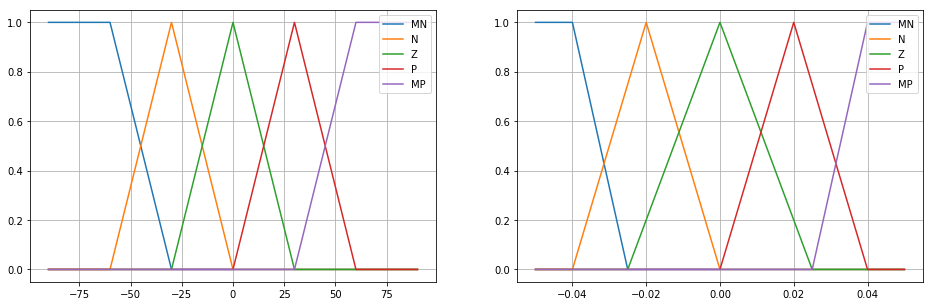

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
for i in theta[1]:
    ax0.plot(theta[0], theta[1][i], label=i)
ax0.grid()
ax0.legend(loc="upper right")

for i in v[1]:
    ax1.plot(v[0], v[1][i], label=i)
ax1.grid()
ax1.legend(loc="upper right")

plt.show()

## Definición de las variable linguísticas y los conjuntos borrosos de salida

Se elige como variable de salida del sistema la fuerza de acción *F* sobre el carro (base del péndulo invertido). Los diferentes conjuntos se denominan igual, solo cambia el rango de valores reales que puede tomar:

In [25]:
F_STEP = 0.5
F = []
F.append(arange(-5, 5+F_STEP, F_STEP))

# Generación de conjuntos borrosos de salida
F.append({})
F[1]['MN'] = generate_profile(-4, F[0], max=-2.5)
F[1]['N'] = generate_profile(-2, F[0], min=-4, max=0)
F[1]['Z'] = generate_profile(0, F[0], min=-2.5, max=2.5)
F[1]['P'] = generate_profile(2, F[0], min=0, max=4)
F[1]['MP'] = generate_profile(4, F[0], min=2.5)

Obteniendose los siguientes conjuntos borrosos para la variable F:

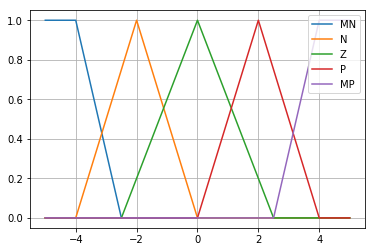

In [26]:
for i in theta[1]:
    plt.plot(F[0], F[1][i], label=i)
plt.grid()
plt.legend(loc="upper right")

## Implementación de la inferencia borrosa mediante base de reglas tipo if-then

Las base de reglas que se estableció para la inferencia borrosa se expone en la siguiente tabla:

    |    | MN | N  | Z  | P  | MP |
    | -- | -- | -- | -- | -- | -- |
    | MN | MN | MN | MN | N  | Z  |
    | N  | MN | MN | N  | Z  | P  |
    | Z  | MN | N  | Z  | P  | MP |
    | P  | N  | Z  | P  | MP | MP |
    | MP | Z  | P  | MP | MP | MP |